# Histogram of Coverage and X Contamination,
using David Reichs ancient data from their annotation file.
Plot and save as .pdfs into ./figures/

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.colors as cls
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


# Functions to Load Data
Load from Eigenstrat Annotation File of D. Reich

In [177]:
def load_eigenstrat_anno(path="./Data/ReichLabEigenstrat/Raw/v37.2.1240K.clean4.anno", anc_only=True):
    """Load annotated Eigenstrat (from D. Reich's group)"""
    df_anno = pd.read_csv(path, sep="\t", engine="python")
    coverage = pd.to_numeric(df_anno["Coverage"], errors='coerce')
    df_anno["coverage"]=coverage

    # Convert the Ages as well
    ages = df_anno["Average of 95.4% date range in calBP (defined as 1950 CE)  "]
    df_anno["ages"] = pd.to_numeric(ages, errors='coerce')  
    
    # Convert X Contamination:
    contX = df_anno["Xcontam point estimate if male and >=200 SNPs"]
    df_anno["contX"] = pd.to_numeric(contX, errors='coerce')
    
    ### Convert Longitude and Latitude
    lat = df_anno["Lat."]
    lon = df_anno["Long."]
    df_anno["lat"] = pd.to_numeric(lat, errors='coerce')
    df_anno["lon"] = pd.to_numeric(lon, errors='coerce')
    df_anno["iid"] = df_anno["Instance ID"]
    
    df_anc = df_anno[df_anno["ages"]>0]

    print(f"Loaded {len(df_anc)} / {len(df_anno)} ancient Indivdiuals.")
    print(f"Without Coverage: {np.sum(np.isnan(coverage))}")
    if anc_only:
        df_anno=df_anc
    return df_anno


def produce_meta_csv(df_anc, save_path = "./Data/ReichLabEigenstrat/Raw/meta.csv"):
    """Produce a formatted meta .csv in my style, to streamline
    further processing (and use same machinery)"""
    ### Transfer the include_alt column
    asmts = df_anc["ASSESSMENT"]
    good = asmts.str.startswith("PASS") # the ones that pass
    bad = asmts.str.startswith("QUES")  # The ones that are "questionable" contamination
    
    assert(len(asmts)==np.sum(good) + np.sum(bad))

    include = np.zeros(len(asmts), dtype="int8")
    include[good]=1
    df_anc["ASSESSMENT"] = include # Save column

    df_save = df_anc[["iid", "lat", "lon", "ages", "Publication", "Group ID", "coverage", "SNPs hit on autosomes", 
                      "ASSESSMENT", "Sex", "contX"]]
    df_save.columns =["iid", "lat", "lon", "age", "study", "clst", "mean_cov", "n_cov_snp", "include_alt", "sex", "contX"]
    if len(save_path)>0:
        df_save.to_csv(save_path, index=False)
        print(f"Saved to {save_path}")
    return df_save

In [178]:
df_anc = load_eigenstrat_anno(path = "./Data/ReichLabEigenstrat/Raw/v37.2.1240K.clean4.anno", anc_only=True)
df_meta = produce_meta_csv(df_anc, save_path="")
#path = "./Data/ReichLabEigenstrat/Raw/meta.csv"

Loaded 2106 / 5081 ancient Indivdiuals.
Without Coverage: 2581


### Histogram of Ages

In [262]:
def hist_ages(df_meta, fs=14, lim=[0,3.5e4], bin_step=250, figsize=(6,4), xlim=[], ylim=[0,230], 
              lw=1.0, ec="k", c="blue", savepath="", c2="maroon"):
    """Do Histogram of Sample Ages"""
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["age"])
    x_cdf = x_cdf[~np.isnan(x_cdf)]
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)
    
    bins = np.arange(lim[0], lim[1], bin_step) - 0.5 # Make 200 year bins
    ages = df_meta["age"]

    plt.figure(figsize=figsize)
    ax=plt.gca()
    plt.hist(ages, color=c, ec=ec, bins=bins, lw=lw)
    #ax.axvline(0.5, color="red", lw=2)
    plt.ylim(ylim)
    if len(xlim)==0:
        xlim=lim
    ax.set_xlim(xlim)
    plt.xlabel("Avg. Age [years BP]", fontsize=fs)
    plt.ylabel("Count", fontsize=fs)
    ax.text(x=0.37, y=0.8, 
            s=f"Total Number ancients: {len(df_anc)}", transform=ax.transAxes, fontsize=fs)
    
    ax2 = ax.twinx()
    ax2.plot(x_cdf, y_cdf, c=c2, lw=1.4)
    ax2.set_ylabel("CDF", color=c2, rotation=270, fontsize=fs)
    ax2.set_ylim([0,1])
    plt.setp(ax2.get_yticklabels(), color=c2)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/manuscript/histograms/hist_ages.pdf


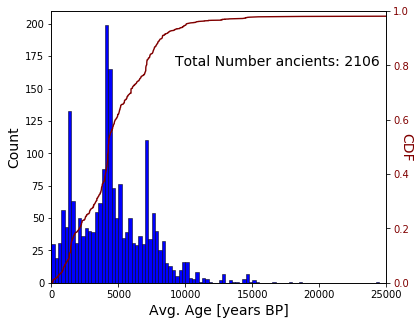

In [263]:
hist_ages(df_meta, figsize=(6,5), ec="k", c="blue", lw=0.5, ylim=[0,210], 
          lim=[0,2.5e4], savepath="./figures/manuscript/histograms/hist_ages.pdf")

### Histogram of Coverage 1240k SNPs

In [256]:
def hist_coverage(df_meta, figsize=(8,4), c="blue", ec="k", lw=0.5, bins=[0,60], bin_step=1, 
                  xlim=[0,25], ylim=[0,500], savepath="", c2="maroon", fs=14):
    """Plot Histogram of Coverage"""
    
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["mean_cov"])
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)
 
    bins = np.arange(bins[0], bins[1], bin_step)

    plt.figure(figsize=figsize)
    
    ax=plt.gca()
    plt.hist(df_anc["coverage"], color=c, ec=ec, bins=bins, lw=0.5)
    ax.axvline(0.5, color="red", lw=1)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    plt.xlabel(f"Avg. Coverage 1240k (bin width: {bins[1]-bins[0]:.2f})", fontsize=fs)
    plt.ylabel("Count", fontsize=fs)
    #ax.text(x=0.27, y=0.8, 
    #        s=f"Total Number ancients: {len(df_meta)}", transform=ax.transAxes, fontsize=fs)
 
    ax2 = ax.twinx()
    ax2.plot(x_cdf, y_cdf, c=c2, lw=1.4)
    ax2.set_ylabel("CDF", color=c2, rotation=270, fontsize=fs)
    ax2.set_ylim([0,1])
    plt.setp(ax2.get_yticklabels(), color=c2)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/manuscript/histograms/hist_covs.pdf


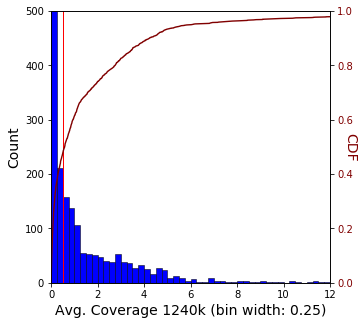

In [261]:
hist_coverage(df_meta, figsize=(5,5), bin_step=0.25, xlim=[0,12], ec="k", c="blue", 
              c2="maroon", savepath="./figures/manuscript/histograms/hist_covs.pdf")

### Histogram of X Contamination

In [259]:
def hist_xcont(df_meta, figsize=(8,4), c="blue", ec="k", lw=0.5, bins=[0,60], bin_step=1, 
                  xlim=[0,1], ylim=[0,200], savepath="", c2="maroon", fs=14):
    """Plot Histogram of Coverage"""
    
    ### Calculate Cumulative Density Function
    x_cdf = np.sort(df_meta["contX"])
    x_cdf = x_cdf[~np.isnan(x_cdf)]
    y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)

    bins = np.arange(bins[0], bins[1], bin_step)

    plt.figure(figsize=figsize)
    
    ax=plt.gca()
    plt.hist(df_meta["contX"], color=c, ec=ec, bins=bins, lw=lw)
    
    ax.axvline(0.5, color="red", lw=1)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    plt.xlabel(f"Estimated X Cont. (bin width: {bins[1]-bins[0]:.3f})", fontsize=fs)
    plt.ylabel("Count", fontsize=fs)

    ax2 = ax.twinx()
    ax2.plot(x_cdf, y_cdf, c=c2, lw=1.4)
    ax2.set_ylabel("CDF", color=c2, rotation=270, fontsize=fs)
    ax2.set_ylim([0,1])
    plt.setp(ax2.get_yticklabels(), color=c2)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/manuscript/histograms/hist_xcont.pdf


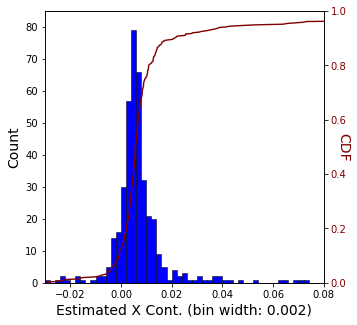

In [260]:
hist_xcont(df_meta, figsize=(5,5), bins=[-0.03,0.08], bin_step=0.002, 
           xlim=[-0.03,0.08], ylim=[0,85], ec="k", c="blue", c2="maroon", savepath="./figures/manuscript/histograms/hist_xcont.pdf")

### Combine these figures here

# Area 51
Test Code here